# SiIV/CIV Ratio Plots 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 40

# update various fontsizes to match
params = {'figure.figsize': (20, 14),
          'legend.fontsize': 20,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 16,
          'xtick.minor.size': 13,
          'ytick.major.size': 16,
          'ytick.minor.size': 13}
plt.rcParams.update(params)

import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList
import glob

import seaborn as sns
pal = sns.color_palette("pastel")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
#Bring in all the COS-Holes fit data and modifying
cosholes_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/cosholes_df.csv')
cosholes_df

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.90,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.002230,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.10,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.003300,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1550.781,0.001494,13.650000,0.050000,0.000,0.000,0.000,0.000,1,0
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1550.781,0.001494,13.500000,0.050000,0.000,0.000,0.000,0.000,1,0
4,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,1548.204,0.000000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1
5,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,166.647701,...,1548.204,0.000510,13.855000,0.052000,34.300,6.220,11.655,3.925,0,1
6,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,62.794963,...,1548.204,0.000810,13.652000,0.103000,10.925,4.852,-2.260,2.533,0,1
7,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,29.956925,...,1548.204,0.001090,13.946000,0.044000,30.000,4.293,-11.070,2.849,0,1
8,NGC3414,J1051,0.004900,1469.80,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.004420,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.00,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.002750,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1


TL;DR
- up_ch = upper limits 
- sum_df = summed values no up lims (USE FOR EVERYTHING BUT VEL PLOT) 
- com_df = comp values no up lims (USE ONLY FOR VEL PLOT)

In [3]:
#DATA frame for just the upper limits 

up_ch = cosholes_df.loc[(cosholes_df['uplim'] == 0)]
up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.65,0.05,0.0,0.0,0.0,0.0,1,0
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.50,0.05,0.0,0.0,0.0,0.0,1,0
11,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,...,1550.781,0.003809,13.38,0.05,0.0,0.0,0.0,0.0,1,0


In [4]:
#Df of just the sums for the whole data set (use this for everything but the relative velocity plot) with no uplims 

sum_ch = cosholes_df.loc[(cosholes_df['comp'] > 0) & (cosholes_df['uplim'] == 1)]
sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.00223,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.00330,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1
4,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,1548.204,0.00000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1
8,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.00442,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.00275,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.00422,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1


In [5]:
#Df of all the components for the whole data set (use this for just the relative velocity plot) with no uplims 
com_ch = cosholes_df.loc[(cosholes_df['comp'] < 2) & (cosholes_df['uplim'] == 1)]
com_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.00223,13.403,0.099,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.00330,13.697,0.074,80.715,17.306,-9.444,12.162,1,1
5,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,166.647701,...,1548.204,0.00051,13.855,0.052,34.300,6.220,11.655,3.925,0,1
6,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,62.794963,...,1548.204,0.00081,13.652,0.103,10.925,4.852,-2.260,2.533,0,1
7,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,29.956925,...,1548.204,0.00109,13.946,0.044,30.000,4.293,-11.070,2.849,0,1
8,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.00442,13.990,0.057,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.00275,14.012,0.076,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.00422,14.211,0.053,54.100,7.973,18.210,5.687,1,1


In [6]:
siiv_cosholes_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/siiv_correct_cosholes_df.csv')
siiv_cosholes_df

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.90,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1393.7602,0.002230,12.540,0.050,0.000,0.000,0.000,0.000,1,0
1,NGC4026,J1159,0.003286,985.10,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1393.7602,0.000000,13.221,0.153,0.000,0.000,0.000,0.000,2,1
2,NGC4026,J1159,0.003286,985.10,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1393.7602,0.002910,12.731,0.124,20.000,10.033,-3.131,6.007,0,1
3,NGC4026,J1159,0.003286,985.10,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1393.7602,0.003340,13.051,0.089,53.300,14.700,-4.440,9.630,0,1
4,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1393.7602,0.001494,12.860,0.050,0.000,0.000,0.000,0.000,1,0
5,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1393.7602,0.001494,12.700,0.050,0.000,0.000,0.000,0.000,1,0
6,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,166.647701,...,1393.7602,0.000510,12.550,0.050,0.000,0.000,0.000,0.000,1,0
7,NGC3414,J1051,0.004900,1469.80,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1393.7602,0.000000,13.651,0.076,0.000,0.000,0.000,0.000,2,1
8,NGC3414,J1051,0.004900,1469.80,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1393.7602,0.004150,13.110,0.068,17.800,4.745,6.094,2.990,0,1
9,NGC3414,J1051,0.004900,1469.80,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1393.7602,0.004480,13.504,0.035,35.298,4.077,-9.390,2.637,0,1


In [7]:
#Bring in all the SiIV Upper Limits 
siiv_up_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/SiIV_upper_limits_updated.csv')
siiv_up_df.set_axis(["ick", "QSO", "NSiIV"], axis="columns", inplace=True)
siiv_up_df = siiv_up_df.drop('ick', axis=1)
siiv_up_df

,QSO,NSiIV
0,J1101,12.54
1,J1220,12.86
2,J1222,12.70
3,J1249,12.55
4,J1123,12.83
5,J0246,13.09
6,J1235,12.68


### Recap: 
- det = values for SiIV and CIV that are both detections
- up = values that are upper limits for SiiIV and CIV
- updet = values that are upper limits for SiIV but dets for CIV 

In [8]:
#Df of just the sums for the whole data set (use this for everything but the relative velocity plot) with no uplims 

siiv_det = siiv_cosholes_df.loc[(siiv_cosholes_df['comp'] > 0) & (siiv_cosholes_df['uplim'] == 1)]
siiv_det

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1393.7602,0.0,13.221,0.153,0.0,0.0,0.0,0.0,2,1
7,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1393.7602,0.0,13.651,0.076,0.0,0.0,0.0,0.0,2,1


In [9]:
siiv_updet = siiv_cosholes_df.loc[(siiv_cosholes_df['uplim'] == 0)]
siiv_updet = siiv_updet.drop([4,5,12])
siiv_updet

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.77,0.065,10.20,11.782755,-0.967,10.751189,...,1393.7602,0.00223,12.54,0.05,0.0,0.0,0.0,0.0,1,0
6,NGC4736,J1249,0.001027,307.8,6.83,0.123,10.62,12.154667,-0.061,166.647701,...,1393.7602,0.00051,12.55,0.05,0.0,0.0,0.0,0.0,1,0
10,NGC3627,J1123,0.002430,721.0,6.92,0.048,10.84,12.455645,0.536,117.031587,...,1393.7602,0.00275,12.83,0.05,0.0,0.0,0.0,0.0,1,0
11,NGC1097,J0246,0.004240,1271.1,8.14,0.090,10.50,12.029020,0.766,24.205849,...,1393.7602,0.00422,13.09,0.05,0.0,0.0,0.0,0.0,1,0


In [10]:
#DATA frame for just the upper limits 

siiv_up = siiv_cosholes_df.loc[(siiv_cosholes_df['uplim'] == 0)]
siiv_up = siiv_up.drop([0,6,10,11])
siiv_up

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
4,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1393.7602,0.001494,12.86,0.05,0.0,0.0,0.0,0.0,1,0
5,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1393.7602,0.001494,12.70,0.05,0.0,0.0,0.0,0.0,1,0
12,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,...,1393.7602,0.003809,12.68,0.05,0.0,0.0,0.0,0.0,1,0


In [11]:
#Creating CIV dets that match the siiv det one  (ms = match siiv)
civ_J1159 = cosholes_df.loc[(cosholes_df['comp'] > 0) & (cosholes_df['QSO'] == 'J1159')]
civ_J1051 = cosholes_df.loc[(cosholes_df['comp'] > 0) & (cosholes_df['QSO'] == 'J1051')]

frames = [civ_J1159, civ_J1051]
civ_det = pd.concat(frames)
civ_det

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.00330,13.697,0.074,80.715,17.306,-9.444,12.162,1,1
8,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.00442,13.990,0.057,32.780,5.621,6.646,3.813,1,1


In [12]:
#Need to create a CIV ups that match the siiv ups (ms = match siiv)

civ_sum = cosholes_df.loc[(cosholes_df['comp'] > 0)]
civ_up = civ_sum.drop([0,1,4,8,9,10])
civ_up

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.65,0.05,0.0,0.0,0.0,0.0,1,0
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.50,0.05,0.0,0.0,0.0,0.0,1,0
11,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,...,1550.781,0.003809,13.38,0.05,0.0,0.0,0.0,0.0,1,0


In [13]:
#Need to create a CIV ups that match the siiv ups (ms = match siiv)

civ_updet = cosholes_df.loc[(cosholes_df['comp'] > 0)]
civ_updet = civ_sum.drop([1,2,3,8,11])
civ_updet

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.77,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.00223,13.403000,0.099000,35.7,11.549,2.357,7.816,1,1
4,NGC4736,J1249,0.001027,307.8,6.83,0.123,10.62,12.154667,-0.061,0.000000,...,1548.204,0.00000,14.311323,0.123487,0.0,0.000,0.000,0.000,2,1
9,NGC3627,J1123,0.002430,721.0,6.92,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.00275,14.012000,0.076000,85.0,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.1,8.14,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.00422,14.211000,0.053000,54.1,7.973,18.210,5.687,1,1


In [14]:
civ_frames = [civ_det, civ_updet, civ_up]
siiv_frames = [siiv_det, siiv_updet, siiv_up]

full_df_civ = pd.concat(civ_frames)
full_df_siiv = pd.concat(siiv_frames)

In [15]:
full_df_civ

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
1,NGC4026,J1159,0.003286,985.10,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.003300,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1
8,NGC3414,J1051,0.004900,1469.80,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.004420,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1
0,NGC3489,J1101,0.002258,676.90,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.002230,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1
4,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,1548.204,0.000000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1
9,NGC3627,J1123,0.002430,721.00,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.002750,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.10,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.004220,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1550.781,0.001494,13.650000,0.050000,0.000,0.000,0.000,0.000,1,0
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1550.781,0.001494,13.500000,0.050000,0.000,0.000,0.000,0.000,1,0
11,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.000000,...,1550.781,0.003809,13.380000,0.050000,0.000,0.000,0.000,0.000,1,0


In [16]:
full_df_siiv

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
1,NGC4026,J1159,0.003286,985.10,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1393.7602,0.000000,13.221,0.153,0.0,0.0,0.0,0.0,2,1
7,NGC3414,J1051,0.004900,1469.80,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1393.7602,0.000000,13.651,0.076,0.0,0.0,0.0,0.0,2,1
0,NGC3489,J1101,0.002258,676.90,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1393.7602,0.002230,12.540,0.050,0.0,0.0,0.0,0.0,1,0
6,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,166.647701,...,1393.7602,0.000510,12.550,0.050,0.0,0.0,0.0,0.0,1,0
10,NGC3627,J1123,0.002430,721.00,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1393.7602,0.002750,12.830,0.050,0.0,0.0,0.0,0.0,1,0
11,NGC1097,J0246,0.004240,1271.10,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1393.7602,0.004220,13.090,0.050,0.0,0.0,0.0,0.0,1,0
4,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1393.7602,0.001494,12.860,0.050,0.0,0.0,0.0,0.0,1,0
5,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1393.7602,0.001494,12.700,0.050,0.0,0.0,0.0,0.0,1,0
12,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.000000,...,1393.7602,0.003809,12.680,0.050,0.0,0.0,0.0,0.0,1,0


Idea: I want to make arrays of the subtraction for N and sigN and then add that to the full_df_civ and then break into sections again based on det, updet, and up so that I can make these damn plots 

In [17]:
N_siiv = np.array(full_df_siiv['N'])
N_civ = np.array(full_df_civ['N'])

N_ratio = N_siiv - N_civ

In [18]:
N_sigsiiv = np.array(full_df_siiv['sigN'])
N_sigciv = np.array(full_df_civ['sigN'])

sigN_ratio = np.sqrt(np.abs(N_sigsiiv**2 - N_sigciv**2))
sigN_ratio

array([0.13391415, 0.05026927, 0.08544589, 0.11291147, 0.05723635,
       0.0175784 , 0.        , 0.        , 0.        ])

In [19]:
qso = np.array(full_df_civ['QSO'])
qso

array(['J1159', 'J1051', 'J1101', 'J1249', 'J1123', 'J0246', 'J1220',
       'J1222', 'J1235'], dtype=object)

In [20]:
comp = np.array(full_df_siiv['comp'])
uplim = np.array(full_df_siiv['uplim'])

In [21]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the sum values 
ratio_vals = {'QSO': qso,
              'NSiIV': N_siiv,
              'sigNSiIV': N_sigsiiv,
           'Nratio': N_ratio,
           'sigNratio': sigN_ratio,
              'compSiIV': comp,
              'uplimSiIV': uplim
          }
rvals = pd.DataFrame(data=ratio_vals)
rvals

,QSO,NSiIV,sigNSiIV,Nratio,sigNratio,compSiIV,uplimSiIV
0,J1159,13.221,0.153,-0.476000,0.133914,2,1
1,J1051,13.651,0.076,-0.339000,0.050269,2,1
2,J1101,12.540,0.050,-0.863000,0.085446,1,0
3,J1249,12.550,0.050,-1.761323,0.112911,1,0
4,J1123,12.830,0.050,-1.182000,0.057236,1,0
5,J0246,13.090,0.050,-1.121000,0.017578,1,0
6,J1220,12.860,0.050,-0.790000,0.000000,1,0
7,J1222,12.700,0.050,-0.800000,0.000000,1,0
8,J1235,12.680,0.050,-0.700000,0.000000,1,0


In [22]:
#New larger df with R25 values included 
ratio_df = pd.merge(full_df_civ, rvals, on="QSO")
ratio_df

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,vel,sigvel,comp,uplim,NSiIV,sigNSiIV,Nratio,sigNratio,compSiIV,uplimSiIV
0,NGC4026,J1159,0.003286,985.10,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,-9.444,12.162,1,1,13.221,0.153,-0.476000,0.133914,2,1
1,NGC3414,J1051,0.004900,1469.80,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,6.646,3.813,1,1,13.651,0.076,-0.339000,0.050269,2,1
2,NGC3489,J1101,0.002258,676.90,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,2.357,7.816,1,1,12.540,0.050,-0.863000,0.085446,1,0
3,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,0.000,0.000,2,1,12.550,0.050,-1.761323,0.112911,1,0
4,NGC3627,J1123,0.002430,721.00,6.920,0.048,10.84,12.455645,0.536,117.031587,...,-21.098,12.763,1,1,12.830,0.050,-1.182000,0.057236,1,0
5,NGC1097,J0246,0.004240,1271.10,8.140,0.090,10.50,12.029020,0.766,24.205849,...,18.210,5.687,1,1,13.090,0.050,-1.121000,0.017578,1,0
6,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,0.000,0.000,1,0,12.860,0.050,-0.790000,0.000000,1,0
7,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,0.000,0.000,1,0,12.700,0.050,-0.800000,0.000000,1,0
8,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.000000,...,0.000,0.000,1,0,12.680,0.050,-0.700000,0.000000,1,0


In [23]:
ratio_det = ratio_df.drop([2,3,4,5,6,7,8])
ratio_det 

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,vel,sigvel,comp,uplim,NSiIV,sigNSiIV,Nratio,sigNratio,compSiIV,uplimSiIV
0,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,-9.444,12.162,1,1,13.221,0.153,-0.476,0.133914,2,1
1,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,6.646,3.813,1,1,13.651,0.076,-0.339,0.050269,2,1


In [24]:
ratio_updet = ratio_df.drop([0,1,6,7,8])
ratio_updet 

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,vel,sigvel,comp,uplim,NSiIV,sigNSiIV,Nratio,sigNratio,compSiIV,uplimSiIV
2,NGC3489,J1101,0.002258,676.9,6.77,0.065,10.20,11.782755,-0.967,10.751189,...,2.357,7.816,1,1,12.54,0.05,-0.863000,0.085446,1,0
3,NGC4736,J1249,0.001027,307.8,6.83,0.123,10.62,12.154667,-0.061,0.000000,...,0.000,0.000,2,1,12.55,0.05,-1.761323,0.112911,1,0
4,NGC3627,J1123,0.002430,721.0,6.92,0.048,10.84,12.455645,0.536,117.031587,...,-21.098,12.763,1,1,12.83,0.05,-1.182000,0.057236,1,0
5,NGC1097,J0246,0.004240,1271.1,8.14,0.090,10.50,12.029020,0.766,24.205849,...,18.210,5.687,1,1,13.09,0.05,-1.121000,0.017578,1,0


In [25]:
ratio_up = ratio_df.drop([0,1,2,3,4,5])
ratio_up

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,vel,sigvel,comp,uplim,NSiIV,sigNSiIV,Nratio,sigNratio,compSiIV,uplimSiIV
6,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,0.0,0.0,1,0,12.86,0.05,-0.79,0.0,1,0
7,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,0.0,0.0,1,0,12.70,0.05,-0.80,0.0,1,0
8,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,...,0.0,0.0,1,0,12.68,0.05,-0.70,0.0,1,0


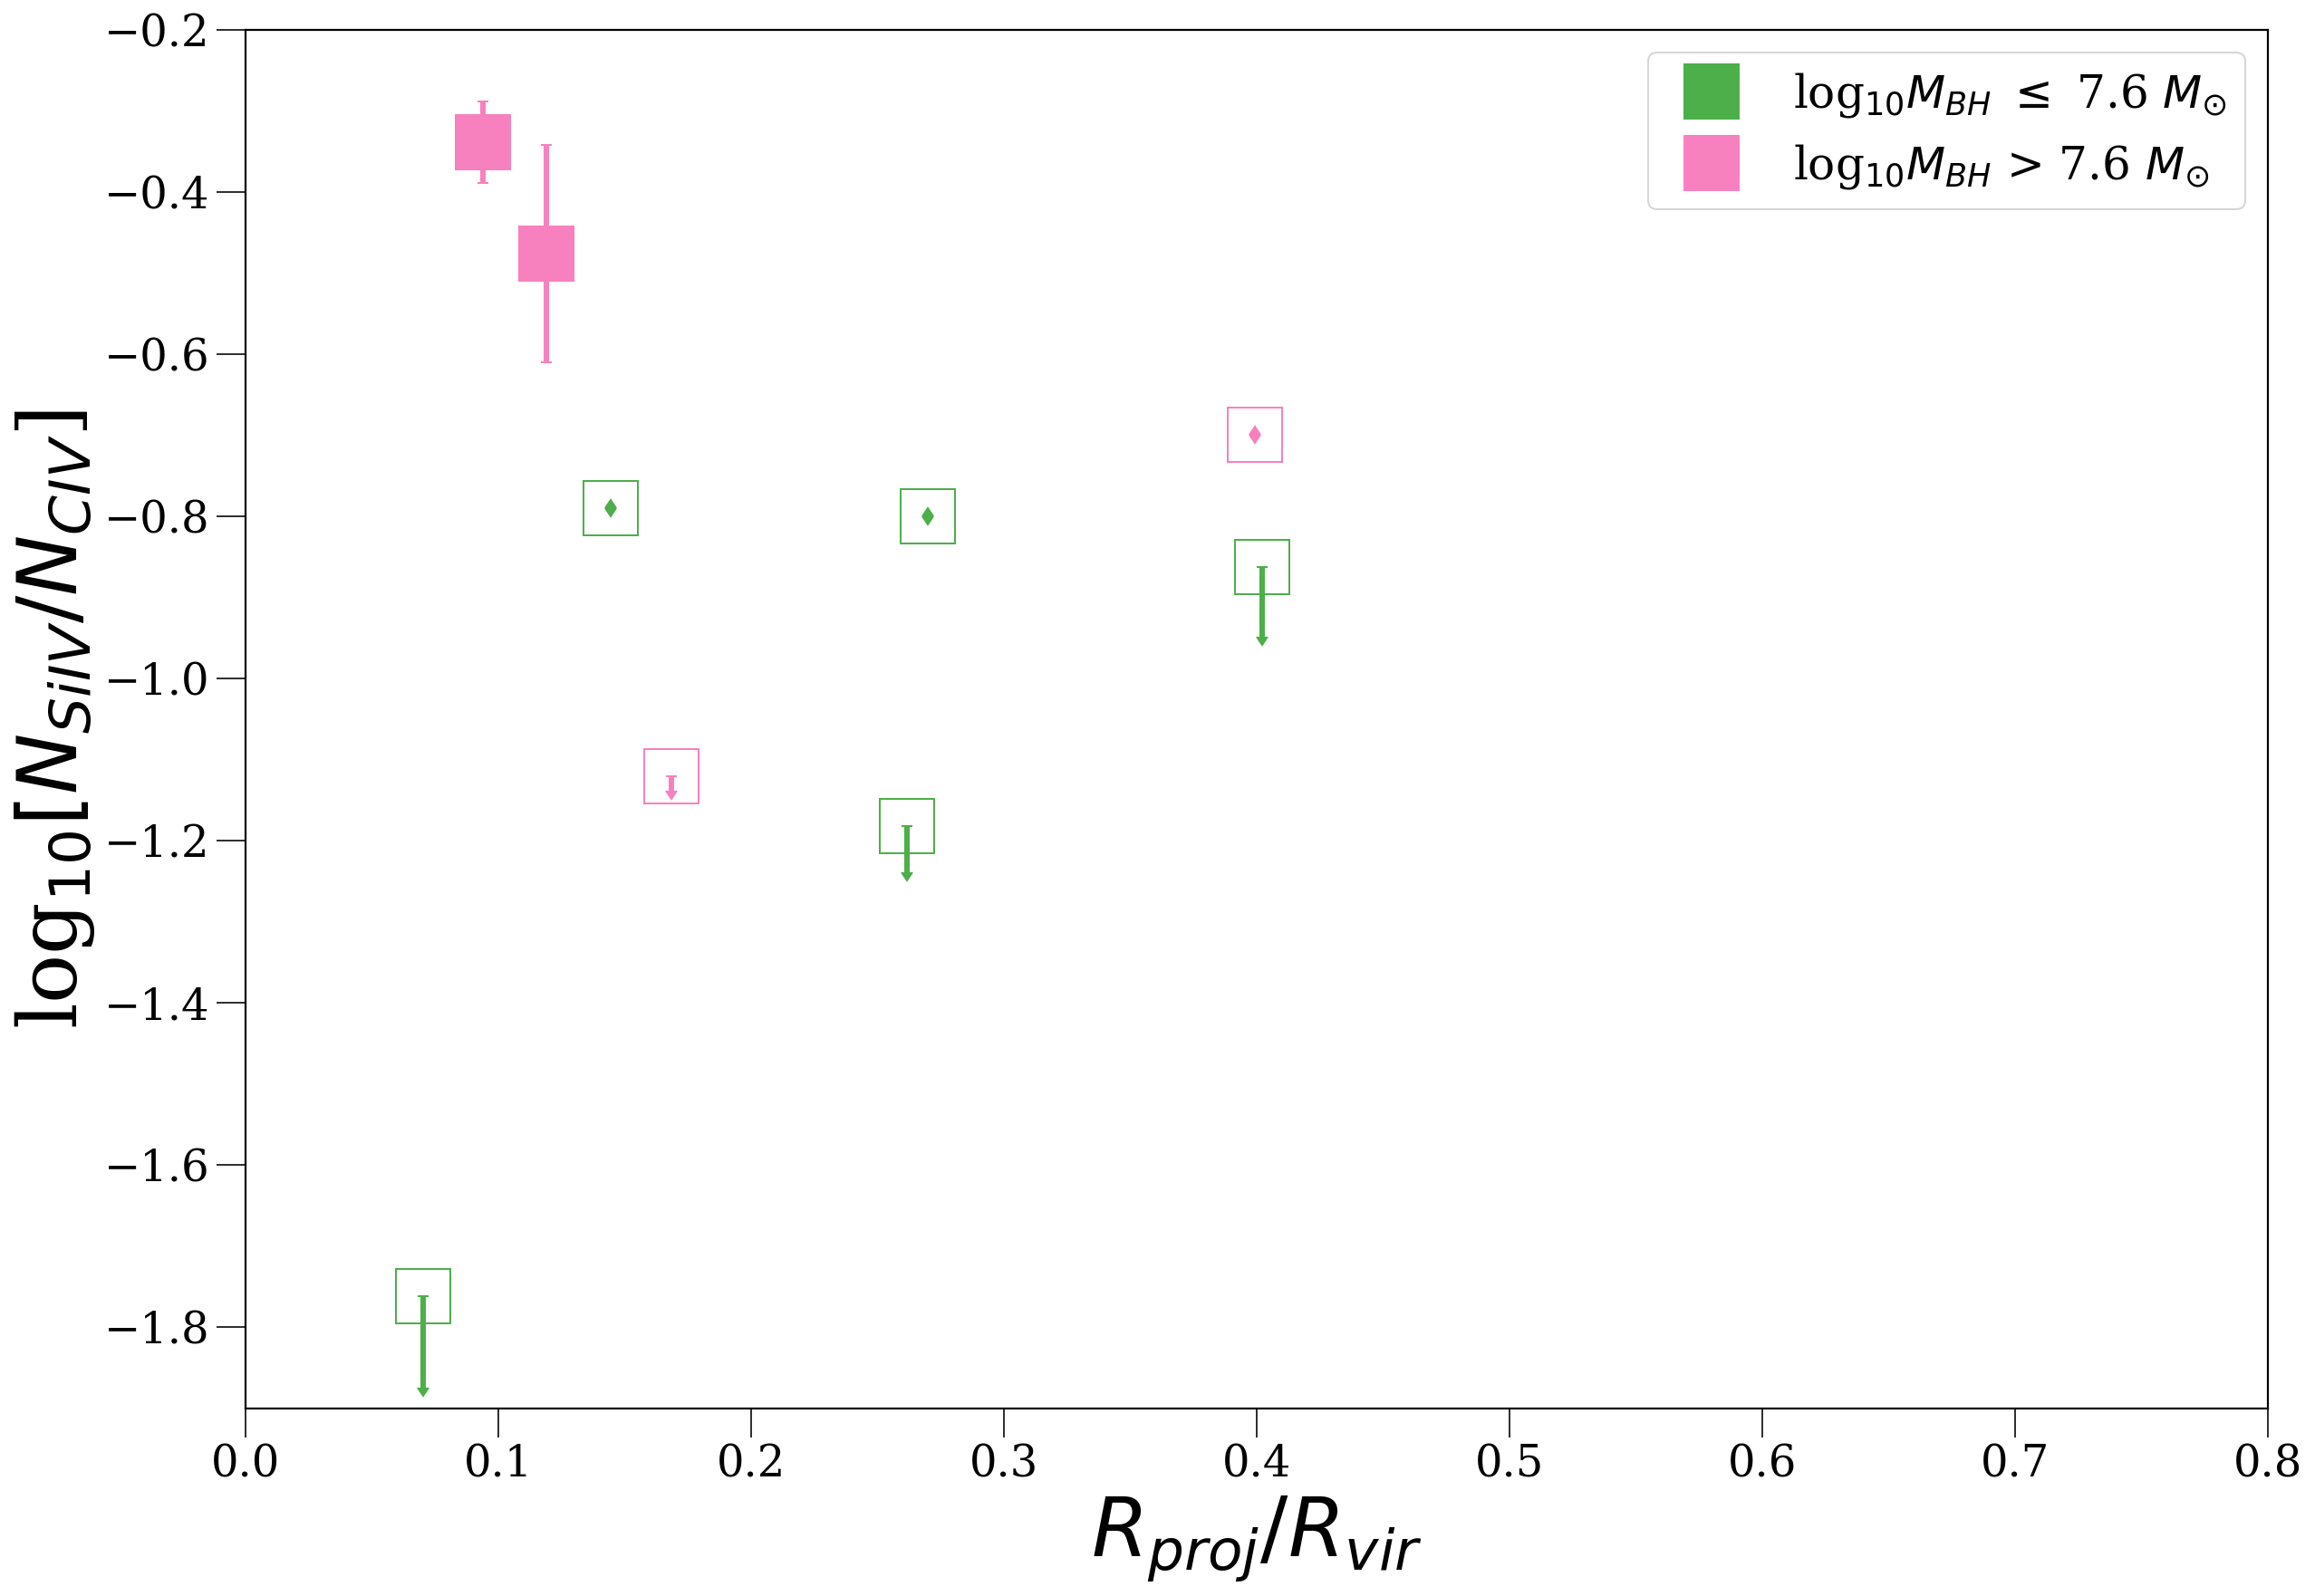

In [26]:
#Plotting NSiIV/ NCIV vs Rproj/Rvir 

#creating masks to separate into high and low 
low_mask_ratio, high_mask_ratio = (ratio_df["MBH"] <= 7.6), (ratio_df["MBH"] > 7.6)

fig, ax = plt.subplots()

########################################################


for mask, colour, label in zip([low_mask_ratio, high_mask_ratio], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    #det/det (should be filled in and have error bars in each direction)
    ax.errorbar(ratio_det["Rproj/Rvir"][mask], ratio_det['Nratio'][mask], 
                yerr = ratio_det['sigNratio'][mask],
                capsize = 3, c = colour, marker="s", markersize=30, ls='none', elinewidth=3, label = label)
    
    #uplim/det (should be unfilled with the marker going down) 
    ax.errorbar(ratio_updet["Rproj/Rvir"][mask], ratio_updet['Nratio'][mask],
                yerr = ratio_updet['sigNratio'][mask], 
                capsize = 3, c = colour, marker="s", markersize=30, ls='none', mfc='none', uplims = True, elinewidth=3)
    
    #uplim/uplim (should be unfilled with marker going in both directions)
    ax.errorbar(ratio_up['Rproj/Rvir'][mask], ratio_up['Nratio'][mask],
                yerr = ratio_up['sigNratio'][mask],
                capsize = 3, c = colour, marker="s", markersize=30, ls='none', mfc='none',  uplims = True, lolims = True,
                elinewidth=3)
    

ax.legend(loc=1, fontsize=25)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}[N_{SiIV}/N_{CIV}$]", fontsize=45)
ax.set_ylim(-1.9, -0.2)
ax.set_xlim(0, 0.8)
plt.show()

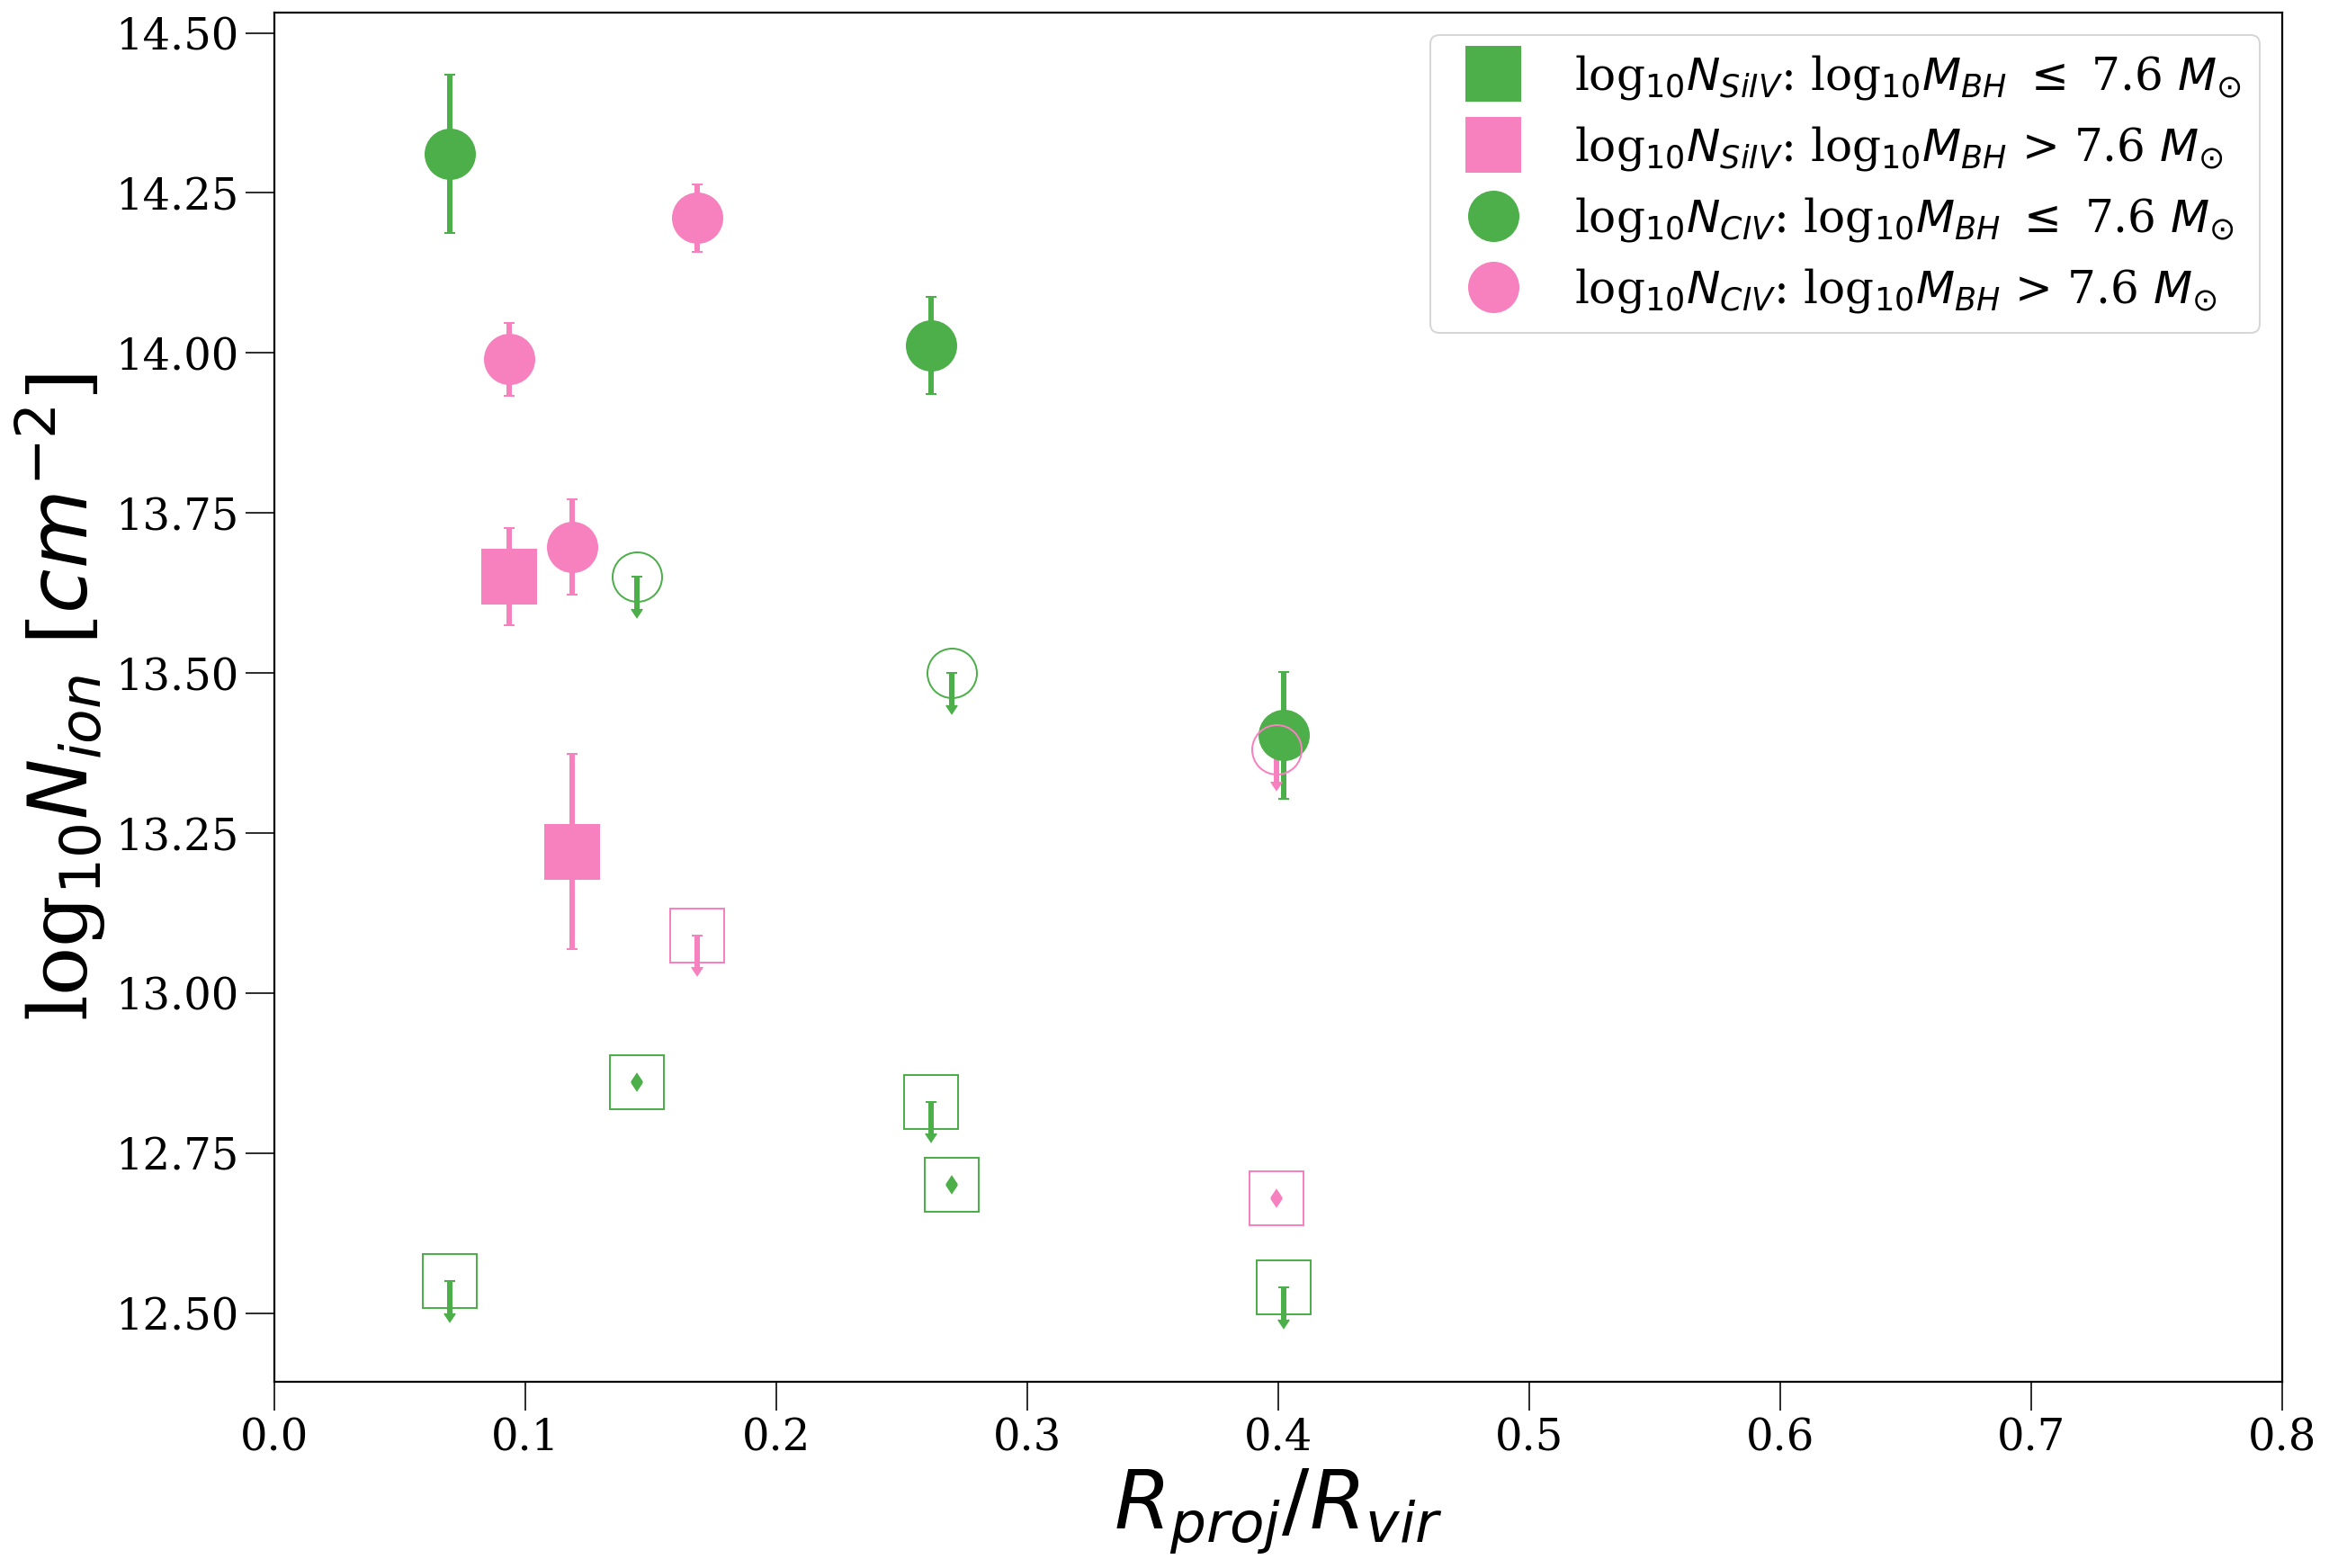

In [27]:
#Plotting NSiIV and NCIV vs Rproj/Rvir 

#creating masks to separate into high and low 
low_mask_ratio, high_mask_ratio = (ratio_df["MBH"] <= 7.6), (ratio_df["MBH"] > 7.6)
low_mask, high_mask = (cosholes_df["MBH"] <= 7.6), (cosholes_df["MBH"] > 7.6)

fig, ax = plt.subplots()

########################################################


for mask, colour, label in zip([low_mask_ratio, high_mask_ratio], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"log$_{10}N_{SiIV}$: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}N_{SiIV}$: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    #det/det (should be filled in and have error bars in each direction)
    ax.errorbar(ratio_det["Rproj/Rvir"][mask], ratio_det['NSiIV'][mask], 
                yerr = ratio_det['sigNSiIV'][mask],
                capsize = 3, c = colour, marker="s", markersize=30, ls='none', elinewidth=3, label = label)
    
    #uplim/det (should be unfilled with the marker going down) 
    ax.errorbar(ratio_updet["Rproj/Rvir"][mask], ratio_updet['NSiIV'][mask],
                yerr = ratio_updet['sigNSiIV'][mask], 
                capsize = 3, c = colour, marker="s", markersize=30, ls='none', mfc='none', uplims = True, elinewidth=3)
    
    #uplim/uplim (should be unfilled with marker going in both directions)
    ax.errorbar(ratio_up['Rproj/Rvir'][mask], ratio_up['NSiIV'][mask],
                yerr = ratio_up['sigNSiIV'][mask],
                capsize = 3, c = colour, marker="s", markersize=30, ls='none', mfc='none',  uplims = True, lolims = True,
                elinewidth=3)
#CIV
for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"log$_{10}N_{CIV}$: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}N_{CIV}$: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)
    

ax.legend(loc=1, fontsize=25)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{ion}$ [$cm^{-2}$]", fontsize=45)
#ax.set_ylim(-1.9, -0.2)
ax.set_xlim(0, 0.8)
plt.show()